In [1]:
from vlm_drive.simulation.carla_sim import CarlaSim
from vlm_drive.simulation.vehicle import Vehicle

carla_sim = CarlaSim()


In [4]:
wp_handler = WaypointHandler()

vehicle = Vehicle(carla_sim, wp_handler)

In [3]:
from carla import Location, Rotation, Transform

class WaypointHandler:
    def __init__(self, start_waypoint="start", first_goal_waypoint="first_sign"):
        self.waypoints = {
            "start": Transform(Location(x=-300.2, y=-287.8, z=82.5), Rotation(yaw=0)),
            "first_sign": Transform(Location(x=-140, y=-224, z=76), Rotation(yaw=25)),
            "mid3": Transform(Location(x=185.6, y=-15.3, z=-24), Rotation(yaw=35)),
            "first_left_goal": Transform(Location(x=237.9, y=-267.5, z=80), Rotation(yaw=90)),
            "mid1": Transform(Location(x=-60.4, y=260.8, z=36), Rotation(yaw=180)),
            "mid2": Transform(Location(x=70, y=-69, z=-15), Rotation(yaw=40)),
            "second_sign": Transform(Location(x=163, y=-31.4, z=-20), Rotation(yaw=40)),
            "second_straight_goal": Transform(Location(x=40, y=182, z=-39), Rotation(yaw=180)),
            "second_right_goal": Transform(Location(x=46, y=74, z=-57), Rotation(yaw=180)),
        }

        self.spawn_waypoint = start_waypoint
        self.current_waypoint = start_waypoint
        self.next_waypoint = first_goal_waypoint

    def get_spawn_waypoint(self):
        return self.waypoints[self.spawn_waypoint]
    
    def get_current_waypoint(self):
        return self.waypoints[self.current_waypoint]
    
    def get_next_waypoint(self):
        return self.waypoints[self.next_waypoint]

    def update_current_waypoint(self):
        self.current_waypoint = self.next_waypoint

    def update_next_wp_from_direction(self, direction_decision: str):
        if self.current_waypoint == "first_sign":
            if direction_decision == "left":
                self.next_waypoint = "first_left_goal"
            elif direction_decision == "straight":
                self.next_waypoint = "second_sign"
        elif self.current_waypoint == "second_sign":
            if direction_decision == "straight":
                self.next_waypoint = "second_straight_goal"
            elif direction_decision == "right":
                self.next_waypoint = "second_right_goal"
        else:
            print("No waypoint found for direction decision")

Todo: Second straight goal fix (out of map)
Second right goal maybe fix

Starting navigation
Driving...
--------------------------------------------------------------------------------------------
Waypoint has been reached.


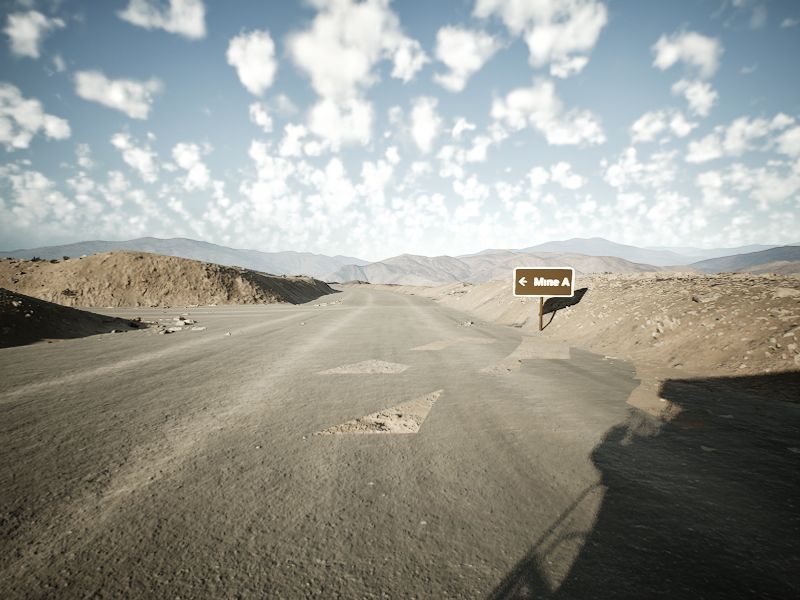

VLAM thinking...
VLAM output: {'destination_reached': False, 'direction': 'left', 'reasononing': 'The sign indicates that Mine A is to the left.'} 

Driving...
--------------------------------------------------------------------------------------------
Waypoint has been reached.


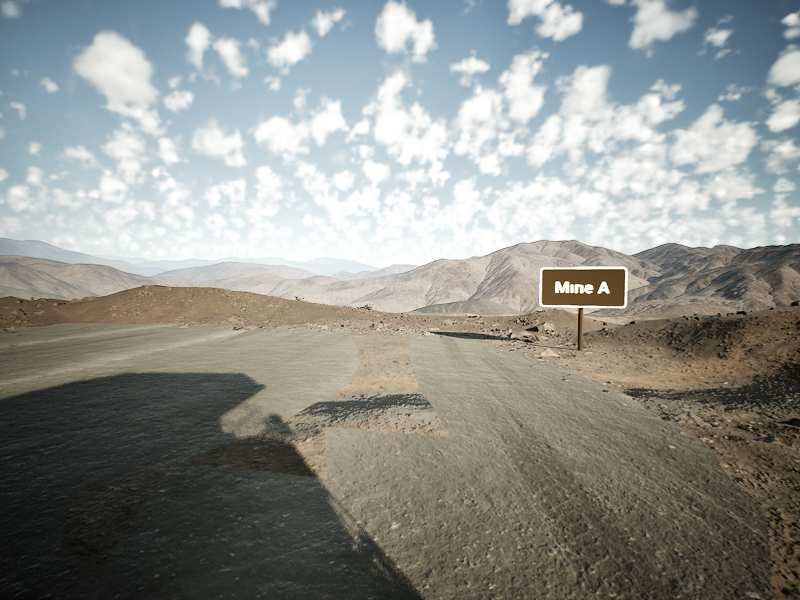

VLAM thinking...
VLAM output: {'destination_reached': True, 'direction': 'straight', 'reasononing': 'The sign says Mine A, so I have reached the destination.'} 

Destination reached!


In [5]:
from IPython.display import display

vlam = VisionLanguageActionModel(backend="google", temperature=0.0)

instruction = "Please drive this car to Mine A."

print("Starting navigation")
while True:        
    # Drive to destination and take an image
    vehicle.drive_to_next_waypoint()
    destination_image = vehicle.get_current_frame()
    display(destination_image)
    
    destination_reached, direction_decision = vlam.consult(destination_image, instruction)

    if not destination_reached:
        wp_handler.update_next_wp_from_direction(direction_decision)
    else:
        print("Destination reached!")
        break
    

In [7]:
vehicle.destroy()

In [27]:
carla_sim.client.reload_world()

In [2]:
from pydantic import BaseModel
import json
from vlm_drive.integrations.google_api import GoogleAPI
from vlm_drive.integrations.vllm_api import VLLMAPI

class VisionLanguageActionModel:
    def __init__(self, backend="google", temperature=0.0):
        if backend == "google":
            self.vlm = GoogleAPI(temperature=temperature)
        elif backend == "vllm":
            self.vlm = VLLMAPI(temperature=temperature)
        else:
            raise NotImplementedError(f"Backend {backend} not implemented")

    def consult(self, destination_image, instruction):

        class NavDescription(BaseModel):
            reasononing: str
            direction: str
            destination_reached: bool

        full_prompt = """
        You are navigating a car, and are given the following instruction as navigation destination goal:
        {instruction}

        There are three Mines A, B and C and there are different road signs leading towards them. Keep goings straight if there is no sign for 
        the instructed destination. The mines itself have a sign without a direction.
        At every sign you are prompted to give a direction out of "right", "left" and "straight", a short reasoning for your decision
        in the following JSON schema and wheter you reached the given destination:

        {{"reasononing": brief sentence, "direction": "right OR left OR straight", "destination_reached": true/false}}

        Start with the reasoning to come to a conclusion before deciding on the direction.
        """
        
        # Fill in the instruction in the prompt
        filled_prompt = full_prompt.format(instruction=instruction)
                        
        # Generate structured response from image and convert to dict
        print("VLAM thinking...")
        answer = self.vlm.generate_structured_response_from_pil_image(filled_prompt, destination_image, response_schema=NavDescription)
        answer_dict = json.loads(answer)
        print("VLAM output:", answer_dict, "\n")
        
        return answer_dict["destination_reached"], answer_dict["direction"]